In [ ]:
## given and entire unsolved sudoku, what is the value of just one cell? let's say, the first cell. 

In [120]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import random
import matplotlib.pyplot as plt


def their_data(filename, size):
	DATA_SIZE = size
	quizzes = np.zeros((DATA_SIZE, 81), np.int32)
	solutions = np.zeros((DATA_SIZE, 81), np.int32)
	for i, line in enumerate(open(filename, 'r').read().splitlines()[1:]):
	    quiz, solution = line.split(",")
	    for j, q_s in enumerate(zip(quiz, solution)):
	        q, s = q_s
	        quizzes[i, j] = q
	        solutions[i, j] = s

	quizzes = quizzes.reshape((-1, 9, 9))
	solutions = solutions.reshape((-1, 9, 9))
	return quizzes, solutions



def my_data(filename, size):
	DATA_SIZE = size
	quizzes = np.zeros((DATA_SIZE, 81), np.int32)
	solutions = np.zeros((DATA_SIZE, 81), np.int32)
	for i, line in enumerate(open(filename, 'r').read().splitlines()[1:]):
	    quiz, solution = line.split(",")
	    quiz = quiz[1:-1]
	    solution = solution[2:-1]
	    for j, q_s in enumerate(zip(quiz, solution)):
	        q, s = q_s
	        quizzes[i, j] = q
	        solutions[i, j] = s
	quizzes = quizzes.reshape((-1, 9, 9))
	solutions = solutions.reshape((-1, 9, 9))
	return quizzes, solutions


#qmillion, smillion = my_data("mixedSudokusBetter.csv", 1000000)
q30k, s30k = my_data("30k_mixedSudokus75_80.csv", 30000)
q80, s80 = my_data("s_make80.csv", 5000)
#qbig, sbig = their_data("1mTheirSudokus.csv", 1000000)
#print("Done with trivial files")
q1m, s1m = my_data("mixedSudokus1m.csv", 1000000)
#print("Done with file q1")
#q2m, s2m = my_data("mixedSudokus2m.csv", 1000000)
#print("Done with file q2")
#q3m, s3m = my_data("mixedSudokus3m.csv", 1000000)
#print("Done with file q3")
#q4m, s4m = my_data("mixedSudokus4m.csv", 1000000)
#print("Done with file reading")


mega_quiz = np.concatenate((q1m, q80, q30k), axis=0)
mega_sol = np.concatenate((s1m, s80, s30k), axis=0)
print("Done with concatenate")

Done with concatenate


In [121]:
mega_sol[0][0][0]

3

In [122]:
## extract the values of the very first cell of each solution
def extract_values(numpy_arr, row, col):
    values_of_cell = []
    for i in range(len(numpy_arr)):
        values_of_cell.append(mega_sol[i][row][col])
    return np.asarray(values_of_cell)

solutions = extract_values(mega_sol,0,0)

print(solutions[0])

solutions.shape

3


(1035000,)

In [123]:
## Shuffle, normalize and add extra dimension to n_qmega because of convolution layers 
SEED = 42
np.random.seed(SEED)
np.random.shuffle(mega_quiz)
np.random.seed(SEED)
np.random.shuffle(solutions)

print("Done with mega shuffle")

n_qmega = mega_quiz / 9.
n_smega = solutions / 9.

print("Done with normalize")

## add extra dimension: 
n_qmega = np.expand_dims(n_qmega, -1)

print("added dimension")

Done with mega shuffle
Done with normalize
added dimension


In [124]:
print(n_qmega[10][0][0][0])
print(n_smega[10])

0.8888888888888888
0.8888888888888888


In [126]:
i = Input(shape=n_qmega[0].shape)
x = Conv2D(16, (3,3), strides=1, activation='relu',padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), strides=1, activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), strides=1, activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(18, activation="relu", bias_initializer="random_normal")(x)
x = Dense(9, activation="relu", bias_initializer="random_normal")(x)
x = Dense(1, activation="linear", bias_initializer="random_normal")(x)

model = Model(i, x)

opt = keras.optimizers.Adam(lr=0.01)
opt2 = keras.optimizers.SGD(lr=0.01, nesterov=True)

## compile and fit model: 

model.compile(optimizer = 'adam',
	loss="mse",
	metrics=["accuracy"])

print(model.summary())

r = model.fit(n_qmega, n_smega, epochs=10, batch_size=500, validation_split=0.001)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 9, 9, 1)]         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 9, 9, 16)          160       
_________________________________________________________________
batch_normalization_25 (Batc (None, 9, 9, 16)          64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 9, 9, 32)          4640      
_________________________________________________________________
batch_normalization_26 (Batc (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
batch_normalization_27 (Batc (None, 9, 9, 64)          256

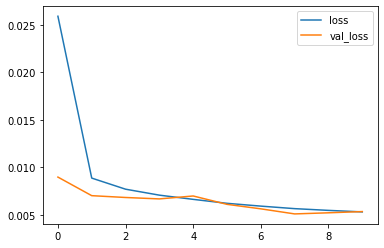

In [127]:
## Plot model loss over time
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

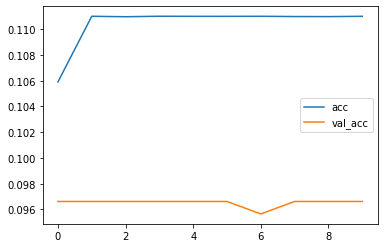

In [128]:
# Plot model accuracy over time
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [129]:
## check model training 

validation = n_qmega[0:15000,:,:,:]
validation_solutions = n_smega[0:15000,]

n_prediction = model.predict(validation)

n_qmega_r = validation.reshape(15000, 9, 9)

n_qmega_r = n_qmega_r * 9
n_prediction = n_prediction * 9
n_smega_r = validation_solutions * 9

print("given: ")
print(np.round(n_qmega_r[0], decimals=0))
print("prediction: ")
print(np.round(n_prediction[0][0], decimals=0))
print("solution: ")
print(np.round(n_smega_r[0], decimals=0))

given: 
[[2. 5. 6. 3. 8. 0. 0. 7. 1.]
 [1. 7. 9. 6. 0. 2. 8. 0. 4.]
 [4. 0. 3. 7. 9. 0. 2. 6. 5.]
 [6. 1. 0. 8. 0. 5. 7. 9. 0.]
 [0. 9. 0. 4. 1. 7. 6. 5. 0.]
 [0. 2. 7. 9. 3. 6. 4. 1. 8.]
 [7. 3. 0. 2. 4. 9. 1. 8. 6.]
 [8. 0. 2. 0. 0. 3. 5. 4. 9.]
 [9. 4. 1. 0. 0. 8. 3. 2. 7.]]
prediction: 
2.0
solution: 
2.0


In [130]:
print(n_prediction[0][0])


1.8366901


In [131]:
## distribution of predicted values: 
preds = np.round(n_prediction, decimals=0)
uniqueValues, occurCount = np.unique(preds, return_counts=True)

print("Unique Values in Prediction: ", uniqueValues)
print("Occurence Count in Prediction: ", occurCount)
print()

Unique Values in Prediction:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Occurence Count in Prediction:  [   1 1459 1755 1633 1670 1846 1826 1804 1528 1465   13]



Text(0, 0.5, 'Frequency')

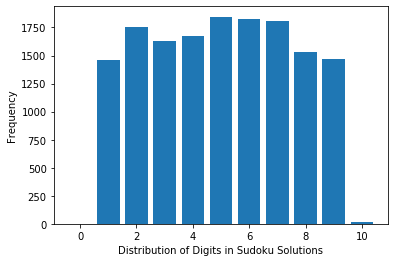

In [132]:
## Plot Range of Values in Prediction
histogramP = plt.bar(uniqueValues, occurCount, )
plt.xlabel('Distribution of Digits in Sudoku Solutions')
plt.ylabel('Frequency')

In [133]:
## check overall accuarcy of predictions 
# n_qmega_r, n_prediction, n_smega_r
def check_predictions(np_arr_prediction, np_arr_solution):
    bool_list =[]
    for i in range(10000):
        bool_list.append(np.round(np_arr_solution[i], decimals=0) == np.round(np_arr_prediction[i][0], decimals=0))
    return bool_list

booleanList = check_predictions(n_prediction, n_smega_r)
trues = booleanList.count(True)
total_accuracy = trues / len(booleanList) * 100

print("####################################################################")
print(total_accuracy, " percent of predicted cells matched the solutions")
print("there were ", trues, " correct predictions in ", len(booleanList), " predictions")
print("####################################################################")
            

####################################################################
87.19  percent of predicted cells matched the solutions
there were  8719  correct predictions in  10000  predictions
####################################################################
